In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import corner
plt.rcParams.update({'font.size': 20})
plt.rc('font',**{'family':'serif'})
plt.rc('text', usetex=True)
from floZ_LossCycle import Trainer
from floZ_LossCycle.train import _pre_whitening

# from floZ_LossCycle import Trainer
# from floZ_LossCycle.train import _pre_whitening

## Initialize dimension and floZ parameters

In [2]:
# Define the likelihood
# N = 1; likelihood_label = str(N)+'Gaussian'
N = 5; likelihood_label = str(N)+'Gaussian'
# likelihood_label = 'Rosenbrock'
# likelihood_label = 'Exponential'

likelihood_label = 'Likelihood-'+likelihood_label

# Dimensions and number of samples.
ndims               = 2
ninput              = 10000 # number of used samples

# general flow settings
flow_type           = 'maf' #options: maf, nvp, nsf

# set layers
num_layers          = ndims+1

# Transformations in MAF
hidden_features     = 5      # 5 transformation
num_blocks          = 2      # 2 optimal
num_bins            = 25     # only nsf and maf

# optimizer settings
learning_rate       = 1e-3
weight_decay        = 1e-6

# dataset settings
n_train_batches     = ninput//50  # Batch size
validation_fraction = 0.2
shuffle_batches     = True
pre_whitening       = True        # Pre-whitening step. Set True

# training settings
training_jitter     = 0.0
max_num_epoch       = 100
patience            = max_num_epoch*10
l2_norm             = 0.0
log_interval        = max_num_epoch//4     # Time period of each loss AND # of epochs that the loss values are displayed in text during run.

# Flag to restrict prior space to cut into the likelihood (a way to ensure likelihood is un-normalized within the prior space)
smallRectangle = False

zflowpath = f'./'+likelihood_label+'_{}d_ninput[{}]_nbatch[{}]_Linterval[{}]'.format(ndims, ninput, n_train_batches, log_interval)
if(smallRectangle):
    zflowpath += '_SmallerRectanglePrior'
print(zflowpath)

./Likelihood-5Gaussian_2d_ninput[10000]_nbatch[200]_Linterval[25]


## Initialize functions to generate and sample from likelihood, and calculate evidence.

In [3]:
from scipy.special import erf
from __future__ import print_function
try:
    import pints
except:
    !pip install pints
    import pints
import pints.toy
import pints.plot
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy import integrate
import random
from scipy.integrate import quad


def get_priors(samples, min_theta, max_theta):
    # Calculate prior values for samples, constant prior
    # print('Flat prior: ln(Prior) = ', -np.log(np.prod(max_theta-min_theta)))
    return np.ones(len(samples))/np.prod(max_theta-min_theta)

###################### N Gaussian initializations ######################

def calc_NGaussian_log_p_Z(samples, min_theta, max_theta, vars):
    likelihood = np.zeros(len(samples))
    Z = 0
    prior = get_priors(samples, min_theta, max_theta)
    
    for id in range(len(vars)):
        # Calculate likelihood values for all samples
        var = vars[id]
        likelihood += var.pdf(samples)
        Z += var.cdf(max_theta) - var.cdf(min_theta)
    likelihood /= N
    Z *= prior[0]/N
    
    # log_p = log (likelihood x prior)
    log_p = np.log(likelihood) + np.log(prior)

    return log_p, Z

def save_NGaussian(path, samples, log_p, limits, Z, means, covs):
    if not os.path.exists(path):
        os.makedirs(path)
    # Saving samples, log(likelihood x prior), logZ
    np.savetxt(os.path.join(path, 'samples_logp.txt'), np.column_stack((samples, log_p)))
    np.savetxt(os.path.join(path, 'limits.txt'), limits) 
    np.savetxt(os.path.join(path, 'Z.txt'), [Z])
    # Saving likelihood properties
    np.save(os.path.join(path, 'means.npy'), means)
    np.save(os.path.join(path, 'covs.npy'), covs)

def load_NGaussian(path):
    s = np.loadtxt(os.path.join(path, 'samples_logp.txt'))
    samples = s[:, :-1]
    log_p = s[:, -1]
    Z = np.loadtxt(os.path.join(path, 'Z.txt'))
    limits = np.loadtxt(os.path.join(path, 'limits.txt'))
    means = np.load(os.path.join(path, 'means.npy'))
    covs = np.load(os.path.join(path, 'covs.npy'))
    return samples, log_p, Z, limits, means, covs


def _init_NGaussian(N, ndims, ninput, zflowpath_ref):
    vars = []
    means = []
    covs = []
    samples = []
    meanmean = np.zeros(ndims)
    for idx in range(N):
        # Generate random mean for each variable
        mean = np.random.uniform(1.,50.,ndims)
        print('Mean ', idx+1)
        print(mean)
        
        meanmean += mean
        means += [mean]
        
        # Generate random variances for each variable
        variances = np.random.uniform(2.8, 8., size=ndims)
        # print('Variances')
        # print(variances)
        
        # Generate a random correlation matrix
        correlation_matrix = np.random.uniform(0, 1, size=(ndims, ndims))
        
        # Set diagonal elements of the correlation matrix to variances
        for i in range(ndims):
            correlation_matrix[i,i] = 1.*variances[i]
            
        # Ensure symmetry
        correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2  
        # print("Correlation Matrix:")
        # print(correlation_matrix)
        
        # Generate the covariance matrix
        covariance_matrix = np.outer(variances, variances) * correlation_matrix
        
        # Make the matrix positive semidefinite
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        covariance_matrix_pos_def = np.dot(eigenvectors, np.dot(np.diag(np.maximum(eigenvalues, 0)), eigenvectors.T))
        
        cov = covariance_matrix_pos_def
        print("Covariance Matrix ", idx+1)
        print(cov)
        covs += [cov]
        
        # Assume flat prior and Gaussian likelihood. Posteriors can be sampled from likelihood, and we take parameter limits outside the sample space.
        samples += list(np.random.multivariate_normal(mean, cov, ninput//N))
        vars += [multivariate_normal(mean=mean, cov=cov)]
    
    meanmean /= N
    
    samples = np.array(samples)
    # print(samples.shape)
    means = np.array(means)
    covs = np.array(covs)
    print('Shapes of means {}, and covariances {}'.format(means.shape, covs.shape))
    min_theta = np.min(samples, axis = 0)
    max_theta = np.max(samples, axis = 0)
    
    log_p, Z = calc_NGaussian_log_p_Z(samples, min_theta, max_theta, vars)
    print('ln Z = ', np.log(Z))
    
    limits = [min_theta, max_theta]
    print('Limits ', limits)
    save_NGaussian(zflowpath_ref, samples, log_p, limits, Z, means, covs)


###################### Define Rosenbrock function ######################

def log_pdf_rosenbrock(x, A=100, B=20):
    x = x.T
    return -np.sum(A*(x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2, axis = 0)/B

# Define the Rosenbrock function
def rosenbrock(x, y):
    return np.exp(log_pdf_rosenbrock(np.array([x,y])))

# Define proposal distribution (Gaussian with diagonal covariance matrix)
def proposal(x, sigma=0.1):
    return np.random.normal(loc=x, scale=sigma)

# Metropolis-Hastings algorithm
def metropolis_hastings(n_samples, initial_state, sigma=0.1):
    samples = [initial_state]
    current_state = initial_state
    for _ in range(n_samples):
        proposed_state = proposal(current_state, sigma)
        acceptance_ratio = min(1, np.exp((-log_pdf_rosenbrock(current_state.T) + log_pdf_rosenbrock(proposed_state.T))))
        if np.random.rand() < acceptance_ratio:
            current_state = proposed_state
        samples.append(current_state)
    return np.array(samples)

def calc_Rosenbrock_log_p_Z(samples, min_theta, max_theta):
    # Calculate likelihood values for samples
    likelihood = np.exp(log_pdf_rosenbrock(x=samples))

    prior = get_priors(samples, min_theta, max_theta)

    # log_p = log (likelihood x prior)
    log_p = np.log(likelihood) + np.log(prior)
    
    # Calculation of Evidence
    if(ndims < 3):
        # Define the limits of integration
        x_lower, x_upper = min_theta[1], max_theta[1]
        y_lower, y_upper = min_theta[0], max_theta[0]
        result, error = integrate.dblquad(rosenbrock, x_lower, x_upper, lambda x: y_lower, lambda x: y_upper)
        print("Integral of Rosenbrock function over the specified domain:", result)
        Z = result/np.prod(max_theta-min_theta)
    else:
        print('Dim > 2, Rosenbrock not integratable: numerically intractable')
        Z = np.nan
    return log_p, Z
    
def save_Rosenbrock(path, samples, log_p, limits, Z):
    if not os.path.exists(path):
        os.makedirs(path)
    # Saving samples, log(likelihood x prior), logZ
    np.savetxt(os.path.join(path, 'samples_logp.txt'), np.column_stack((samples, log_p)))
    np.savetxt(os.path.join(path, 'limits.txt'), limits) 
    np.savetxt(os.path.join(path, 'Z.txt'), [Z])

def load_Rosenbrock(path):
    s = np.loadtxt(os.path.join(path, 'samples_logp.txt'))
    samples = s[:, :-1]
    log_p = s[:, -1]
    Z = np.loadtxt(os.path.join(path, 'Z.txt'))
    limits = np.loadtxt(os.path.join(path, 'limits.txt'))
    return samples, log_p, Z, limits
    
    
def _init_Rosenbrock(ndims, ninput, zflowpath_ref):
    # Initial state
    initial_state = np.zeros(ndims)
    
    # Generate MCMC samples
    samples = metropolis_hastings(ninput, initial_state)

    max_theta = np.max(samples, axis = 0)
    min_theta = np.min(samples, axis = 0)

    log_p, Z = calc_Rosenbrock_log_p_Z(samples, min_theta, max_theta)
    
    print('log Z ', np.log(Z))

    limits = [min_theta, max_theta]
    print('Limits ', limits)
    save_Rosenbrock(zflowpath_ref, samples, log_p, limits, Z)


###################### Exponential functions ###########################

def generate_n_dimensional_exponential(N, lambdas, size):
    """
    Generate an N-dimensional exponential distribution with different lambdas for each dimension.

    Parameters:
    - N: Dimensionality of the distribution.
    - lambdas: Array of rate parameters for each dimension.
    - size: Number of samples to generate.

    Returns:
    - ndarray: N-dimensional array of samples from the exponential distribution.
    """
    samples = np.random.exponential(scale=1 / lambdas, size=(size, N))
    return samples


def n_dimensional_exponential_cdf(x, lambdas):
    """
    Compute the cumulative distribution function (CDF) of an N-dimensional exponential distribution.

    Parameters:
    - x: Numpy array of values at which to compute the CDF for each dimension (shape: (N, M)).
    - lambdas: Numpy array of rate parameters for each dimension (shape: (N,)).

    Returns:
    - ndarray: CDF values for the N-dimensional distribution at the input x (shape: (M,)).
    """
    cdf_values = 1 - np.exp(-lambdas * x)
    return np.prod(cdf_values, axis=0)


def n_dimensional_exponential_pdf(x, lambdas):
    """
    Calculate the probability density for an N-dimensional exponential distribution.

    Parameters:
    - x: N-dimensional array of samples.
    - lambdas: Array of rate parameters for each dimension.

    Returns:
    - float: Probability density for the given sample.
    """
    pdf_values = lambdas * np.exp(-lambdas * x)
    # print(pdf_values)
    return np.prod(pdf_values, axis=1)


def n_dimensional_exponential_logpdf(x, lambdas):
    """
    Calculate the probability density for an N-dimensional exponential distribution.

    Parameters:
    - x: N-dimensional array of samples.
    - lambdas: Array of rate parameters for each dimension.

    Returns:
    - float: Probability density for the given sample.
    """
    log_pdf_values = np.log(lambdas) - lambdas * x
    
    return np.sum(log_pdf_values)
    

def calc_Exponential_log_p_Z(samples, min_theta, max_theta, lambdas):
    # Calculate likelihood values for samples
    log_likelihood = n_dimensional_exponential_logpdf(x=samples, lambdas=lambdas)
    
    prior = get_priors(samples, min_theta, max_theta)

    # log_p = log (likelihood x prior)
    log_p = log_likelihood + np.log(prior)
    
    # Calculation of Evidence
    Z = (n_dimensional_exponential_cdf(x=max_theta, lambdas=lambdas) - n_dimensional_exponential_cdf(x=min_theta, lambdas=lambdas)) *prior[0]
    
    return log_p, Z
    
def save_Exponential(path, samples, log_p, limits, Z, lambdas):
    if not os.path.exists(path):
        os.makedirs(path)
    
    # Saving samples, log(likelihood x prior), logZ
    np.savetxt(os.path.join(path, 'samples_logp.txt'), np.column_stack((samples, log_p)))
    np.savetxt(os.path.join(path, 'limits.txt'), limits) 
    # Saving evidence
    np.savetxt(os.path.join(path, 'Z.txt'), [Z])
    # Saving prior bounds
    np.savetxt(os.path.join(path, 'limits.txt'), limits)
    # Saving likelihood properties
    np.savetxt(os.path.join(path, 'lambdas.txt'), lambdas)

def load_Exponential(path):
    s = np.loadtxt(os.path.join(path, 'samples_logp.txt'))
    samples = s[:, :-1]
    log_p = s[:, -1]
    Z = np.loadtxt(os.path.join(path, 'Z.txt'))
    limits = np.loadtxt(os.path.join(path, 'limits.txt'))
    lambdas = np.loadtxt(os.path.join(path, 'lambdas.txt'))
    return samples, log_p, Z, limits, lambdas


def _init_Exponential(ndims, ninput, zflowpath_ref):
    # Generate random mean for each variable
    lambdas = np.random.uniform(0,1e-2,ndims)
    lambdas = np.round(lambdas, decimals=6)
    print('Lambdas')
    print(lambdas)

    samples = generate_n_dimensional_exponential(N=ndims, lambdas=lambdas, size=ninput)
    
    min_theta = np.min(samples, axis = 0)
    max_theta = np.max(samples, axis = 0)

    log_p, Z = calc_Exponential_log_p_Z(samples, min_theta, max_theta, lambdas)
    print('ln Z = ', np.log(Z))
    
    limits = [min_theta, max_theta]
    print('Limits ', limits)
    save_Exponential(zflowpath_ref, samples, log_p, limits, Z, lambdas)


## Sample generation and calculating log(likelihood x prior) based on selected likelihood and prior distribution.

./Likelihood-5Gaussian_2d_ninput[10000]


Importing samples, means, covs from  ./Likelihood-5Gaussian_2d_ninput[10000]
Imported ln Z =  -10.131224837709091
Shape of imported means (5, 2) and covs (5, 2, 2)
Imported Limits [[-47.54825947 -45.06759682]
 [114.19726912 110.19310645]]
Oversampled sample size  (50000, 2)
Boxed sample size  (49984, 2)
Downsampled sample size (10000, 2)
Recalculated ln Z =  -10.131224837709091


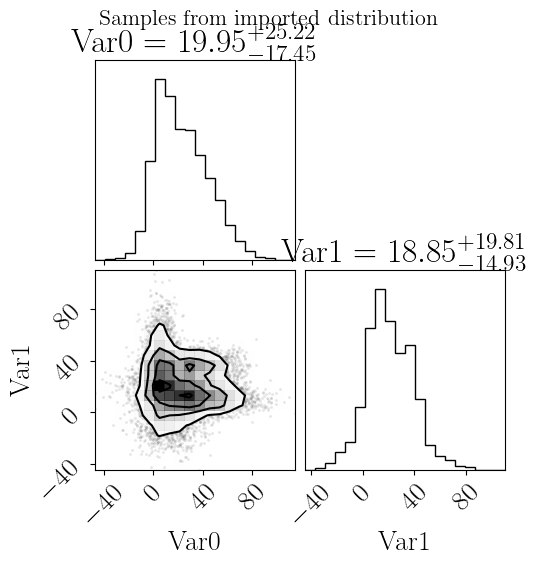

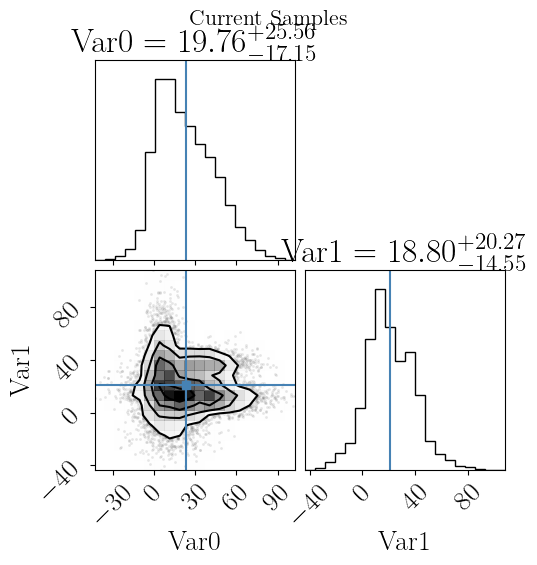

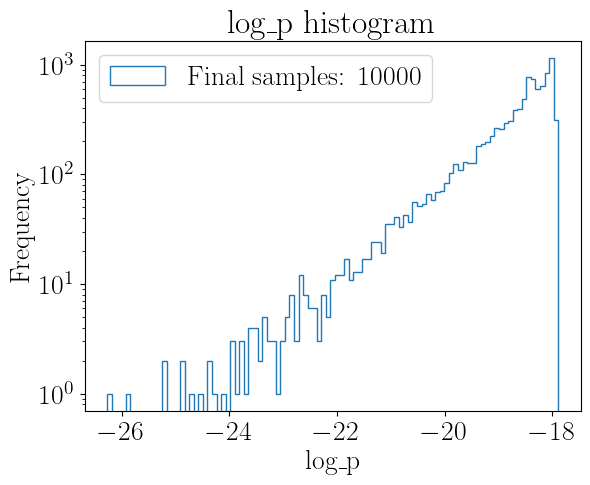

In [4]:
zflowpath_ref = f'./'+likelihood_label+'_{}d_ninput[10000]'.format(ndims)
print(zflowpath_ref)

get_new_distribution = True
if os.path.exists(zflowpath_ref):
    get_new_distribution = False
else:
    os.makedirs(zflowpath_ref)

###################### Rosenbrock ###########################

if(likelihood_label == 'Likelihood-Rosenbrock'):
    if(get_new_distribution):
        _init_Rosenbrock(ndims = ndims, ninput=10000, zflowpath_ref=zflowpath_ref)
        
    print('\n\nImporting samples from ', zflowpath_ref)
    s = np.loadtxt(os.path.join(zflowpath_ref, 'samples_logp.txt'))
    samples_ref = s[:, :-1]
    log_p = s[:, -1]
    Z = np.loadtxt(os.path.join(zflowpath_ref, 'Z.txt'))
    limits = np.loadtxt(os.path.join(zflowpath_ref, 'limits.txt'))
    min_theta = limits[0,:]
    max_theta = limits[1,:]
    print('Imported ln Z = ', np.log(Z))
    
    figure = corner.corner(np.transpose(samples_ref.T), labels=["Var"+str(index) for index in range(len(samples_ref.T))], show_titles=True)
    figure.suptitle("Samples from imported distribution", y=1.02, fontsize=16)
    
    # Restrict prior if smallRectangle flag True
    if(smallRectangle):
        min_theta = limits[0,:] + .3*np.absolute(limits[0,:])
        max_theta =  limits[1,:] - .3*np.absolute(limits[1,:])
        limits = [min_theta, max_theta]
        print('\n!! CAUTION !!\nSmaller prior limits: ', limits, '\n')

    # Generate MCMC samples with loaded prior bounds
    initial_state = np.zeros(ndims)
    samples = metropolis_hastings(6*ninput, initial_state)
    print('Oversampled sample size ', samples.shape)

    # Discard samples outside prior limits.
    for dim in range(ndims):
        samples[np.where((samples[:,dim]>max_theta[dim]) | (samples[:,dim]<min_theta[dim])),:]*=np.nan
    samples=samples[~np.isnan(samples[:,0]), :]
    samples = np.array(samples)
    print('Boxed sample size ', samples.shape)

    # Downsampling to ninputs samples.
    samples=samples[random.sample(range(len(samples)), ninput),:]
    samples = np.array(samples)
    print('Downsampled sample size', samples.shape)

    log_p, Z = calc_Rosenbrock_log_p_Z(samples, min_theta, max_theta)
    print('Recalculated log Z ', np.log(Z))
    
    save_Rosenbrock(zflowpath, samples, log_p, limits, Z)
    meanmean = np.mean(samples, axis = 0)

###################### Exponential ###########################

elif(likelihood_label == 'Likelihood-Exponential'):
    if(get_new_distribution):
        _init_Exponential(ndims = ndims, ninput=10000, zflowpath_ref=zflowpath_ref)

    print('\n\nImporting samples and lambda from ', zflowpath_ref)
    s = np.loadtxt(os.path.join(zflowpath_ref, 'samples_logp.txt'))
    samples_ref = s[:, :-1]
    log_p = s[:,-1]
    Z = np.loadtxt(os.path.join(zflowpath_ref, 'Z.txt'))
    limits = np.loadtxt(os.path.join(zflowpath_ref, 'limits.txt'))
    lambdas = np.loadtxt(os.path.join(zflowpath_ref, 'lambdas.txt'))
    min_theta = limits[0,:]
    max_theta = limits[1,:]
    print('Imported ln Z = ', np.log(Z))
    
    figure = corner.corner(np.transpose(samples_ref.T), labels=["Var"+str(index) for index in range(len(samples_ref.T))], show_titles=True)
    figure.suptitle("Samples from imported distribution", y=1.02, fontsize=16)
    
    # Restrict prior if smallRectangle flag True
    if(smallRectangle):
        min_theta = limits[0,:] + .3*np.absolute(limits[0,:])
        max_theta =  limits[1,:] - .3*np.absolute(limits[1,:])
        limits = [min_theta, max_theta]
        print('\n!! CAUTION !!\nSmaller prior limits: ', limits, '\n')

    # Generate MCMC samples with loaded likelihood and prior bounds
    samples = generate_n_dimensional_exponential(N=ndims, lambdas=lambdas, size=5*ninput)
    print('Oversampled sample size ', samples.shape)
    
    # Discard samples outside prior limits.
    for dim in range(ndims):
        samples[np.where((samples[:,dim]>max_theta[dim]) | (samples[:,dim]<min_theta[dim])),:]*=np.nan
    samples=samples[~np.isnan(samples[:,0]), :]
    samples = np.array(samples)
    print('Boxed sample size ', samples.shape)

    # Downsampling to ninputs samples.
    if(len(samples)>ninput):
        samples=samples[:ninput,:]
        samples = np.array(samples)
    print('Downsampled sample size', samples.shape)

    log_p, Z = calc_Exponential_log_p_Z(samples, min_theta, max_theta, lambdas)
    print('Recalculated log Z ', np.log(Z))

    save_Exponential(zflowpath, samples, log_p, limits, Z, lambdas)
    
    meanmean = np.mean(samples, axis = 0)

###################### NGaussian ###########################

else:
    if(get_new_distribution):
        _init_NGaussian(N, ndims = ndims, ninput=10000, zflowpath_ref=zflowpath_ref)
    
    print('\n\nImporting samples, means, covs from ', zflowpath_ref)
    s = np.loadtxt(os.path.join(zflowpath_ref, 'samples_logp.txt'))
    samples_ref = s[:, :-1]
    Z = np.loadtxt(os.path.join(zflowpath_ref, 'Z.txt'))
    print('Imported ln Z = ', np.log(Z))
    means = np.load(os.path.join(zflowpath_ref, 'means.npy'))
    covs = np.load(os.path.join(zflowpath_ref, 'covs.npy'))
    print('Shape of imported means {} and covs {}'.format(means.shape, covs.shape))
    limits = np.loadtxt(os.path.join(zflowpath_ref, 'limits.txt'))
    print('Imported Limits', limits)
    min_theta = limits[0,:]
    max_theta = limits[1,:]

    figure = corner.corner(np.transpose(samples_ref.T), labels=["Var"+str(index) for index in range(len(samples_ref.T))], show_titles=True)
    figure.suptitle("Samples from imported distribution", y=1.02, fontsize=16)

    # Restrict prior if smallRectangle flag True
    if(smallRectangle):
        min_theta = limits[0,:] + .3*np.absolute(limits[0,:])
        max_theta = limits[1,:] - .3*np.absolute(limits[1,:])
        limits = [min_theta, max_theta]
        print('\n!! CAUTION !!\nSmaller prior limits: ', limits, '\n')

    samples = []
    vars = []
    meanmean = np.zeros(ndims)
    # Sample from loaded likelihood.
    for idx in range(N):
        meanmean += means[idx]
        samples += list(np.random.multivariate_normal(means[idx], covs[idx], 5*ninput//N))
        vars += [multivariate_normal(mean=means[idx], cov=covs[idx])]
    meanmean /= N
    samples = np.array(samples)
    print('Oversampled sample size ', samples.shape)

    # Discard samples outside prior limits.
    for dim in range(ndims):
        samples[np.where((samples[:,dim]>max_theta[dim]) | (samples[:,dim]<min_theta[dim])),:]*=np.nan
    samples=samples[~np.isnan(samples[:,0]), :]
    samples = np.array(samples)
    print('Boxed sample size ', samples.shape)

    # Downsampling to ninputs samples.
    samples=samples[random.sample(range(len(samples)), ninput),:]
    samples = np.array(samples)
    print('Downsampled sample size', samples.shape)

    log_p, Z = calc_NGaussian_log_p_Z(samples, min_theta, max_theta, vars)
    print('Recalculated ln Z = ', np.log(Z))
    
    save_NGaussian(zflowpath, samples, log_p, limits, Z, means, covs)

# Plot the corner plot
figure = corner.corner(np.transpose(samples.T), labels=["Var"+str(index) for index in range(len(samples.T))], show_titles=True, truths=meanmean)
figure.suptitle("Current Samples", y=1.02, fontsize=16)
plt.show()

#sc = plt.scatter(samples.T[0],samples.T[1], c=log_p, cmap='viridis', s=10, alpha=0.7)
#cbar = plt.colorbar(sc, label='log (likelihood x prior)')

plt.figure()
plt.title('log_p histogram')
bins = np.linspace(np.min(log_p), np.max(log_p), 100)
plt.hist(log_p, bins = bins, histtype = 'step', label = 'Final samples: {}'.format(len(log_p)))
plt.yscale('log')
plt.xlabel('log_p')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Initialize floZ Network

In [5]:
# zflows evidence
t       = Trainer(samples, log_p,
                outdir                 = zflowpath,
                seed                   = None,
                device                 = 'cuda',
                # normalizing flow settings
                base_dist              = 'normal',
                transform              = 'maf',
                transform_dict         = {'num_layers':       num_layers,
                                        'num_blocks':       num_blocks,
                                        'hidden_features':  hidden_features,
                                        'num_bins':         num_bins
                                        },
                # optmizer settings
                learning_rate          = learning_rate,
                weight_decay           = weight_decay,
                # data settings
                n_train_batches        = n_train_batches,
                validation_fraction    = validation_fraction,
                shuffle_batches        = shuffle_batches,
                pre_whitening          = pre_whitening,
                lnZ_GT                 = np.log(Z),
                )

[zflows] [04-20-2024 18:03] GT of lnZ: -10.131224837709091


Available GPUs:  1


[zflows] [04-20-2024 18:03] Output directory: /u/r/rsriniva/flows/Likelihood-5Gaussian_2d_ninput[10000]_nbatch[200]_Linterval[25]
[zflows] [04-20-2024 18:03] Dimensions of parameter space: 2
[zflows] [04-20-2024 18:03] Number of input samples: 10000
[zflows] [04-20-2024 18:03] Number of network parameters: 2175
[zflows] [04-20-2024 18:03] Working device: cuda
[zflows] [04-20-2024 18:03] Whitening samples with covariance error of 8.07e-17
[zflows] [04-20-2024 18:03] Splitting input samples in training set (8000) and validation set (2000)


## Training

[zflows] [04-20-2024 18:03] Output directory: /u/r/rsriniva/flows/Likelihood-5Gaussian_2d_ninput[10000]_nbatch[200]_Linterval[25]
[zflows] [04-20-2024 18:03] Starting training of neural network ...


Total # batches:  40


[zflows] [04-20-2024 18:03] > Epoch 1 - train loss -6.51192 - valid loss -7.54102 - best valid loss -7.54102
[zflows] [04-20-2024 18:03] > Epoch 25 - train loss -10.07693 - valid loss -10.06889 - best valid loss -10.06889
[zflows] [04-20-2024 18:03] > Epoch 50 - train loss -13.10679 - valid loss -13.08372 - best valid loss -13.08372
[zflows] [04-20-2024 18:04] > Epoch 75 - train loss 0.00253 - valid loss 0.00455 - best valid loss -13.08372
[zflows] [04-20-2024 18:04] > Epoch 100 - train loss -3.05580 - valid loss -2.98165 - best valid loss -13.08372
[zflows] [04-20-2024 18:04] Completing training of neural network
[zflows] [04-20-2024 18:04] Best epoch (50): train loss -13.10679 - validation loss -13.08372
[zflows] [04-20-2024 18:04] Total training time: 1min 32.123sec
[zflows] [04-20-2024 18:04] Estimated logZ with ratio: -10.12508 ± 0.05893
[zflows] [04-20-2024 18:04] Saving output data
[zflows] [04-20-2024 18:04] Output directory: /u/r/rsriniva/flows/Likelihood-5Gaussian_2d_ninput[1

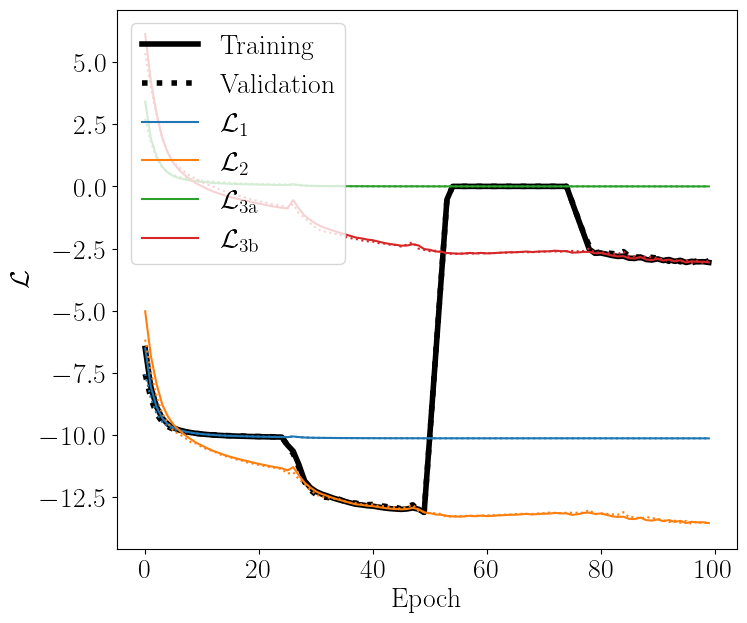

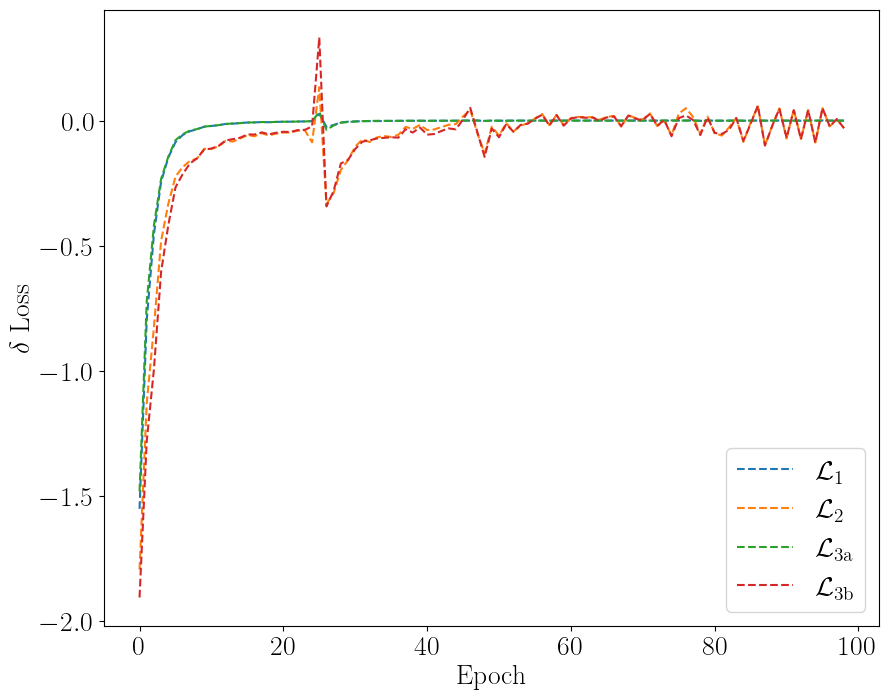

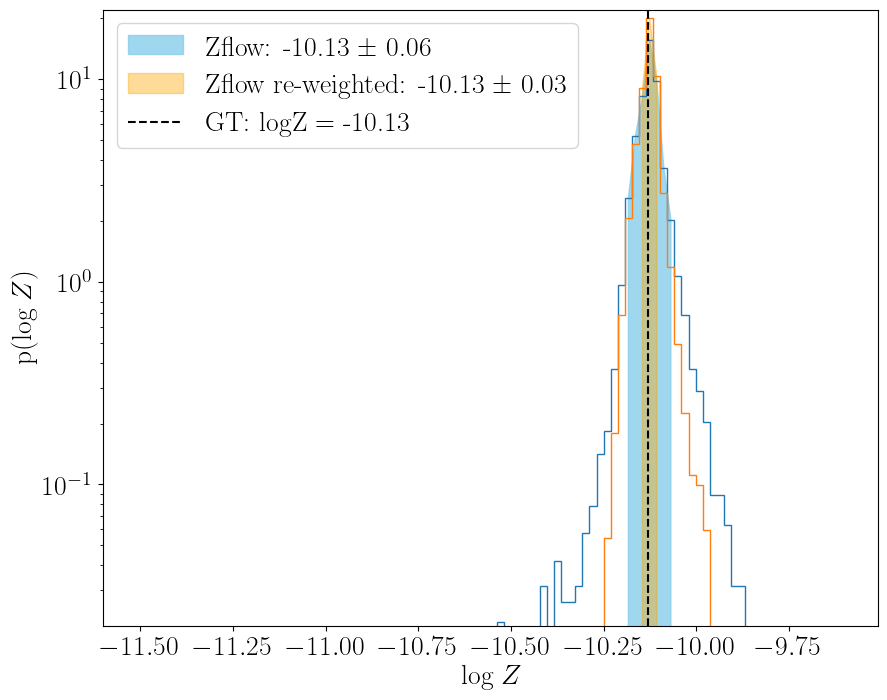

In [6]:
t.train(max_num_epoch   = max_num_epoch,
        patience        = patience,
        tolerance       = 1e-6,
        log_interval    = log_interval)

## Load trained floZ

./Likelihood-5Gaussian_2d_ninput[10000]_nbatch[200]_Linterval[25]


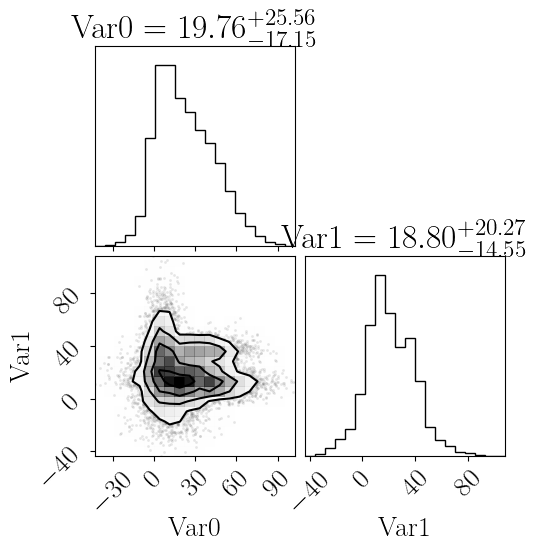

[zflows] [04-20-2024 18:04] GT of lnZ: -10.131224837709091
[zflows] [04-20-2024 18:04] Output directory: /u/r/rsriniva/flows/Likelihood-5Gaussian_2d_ninput[10000]_nbatch[200]_Linterval[25]
[zflows] [04-20-2024 18:04] Dimensions of parameter space: 2
[zflows] [04-20-2024 18:04] Number of input samples: 10000
[zflows] [04-20-2024 18:04] Number of network parameters: 2175
[zflows] [04-20-2024 18:04] Working device: cuda
[zflows] [04-20-2024 18:04] Whitening samples with covariance error of 8.07e-17
[zflows] [04-20-2024 18:04] Splitting input samples in training set (8000) and validation set (2000)


Available GPUs:  1


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): ReversePermutation()
      (1): MaskedPiecewiseQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=5, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=5, out_features=5, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=5, out_features=98, bias=True)
        )
      )
      (2): ReversePermutation()
      (3): MaskedPiecewiseQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=5, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): Mod

In [7]:
print(zflowpath)

if(likelihood_label == 'Likelihood-Rosenbrock'):
    samples, log_p, Z, limits = load_Rosenbrock(zflowpath)
elif(likelihood_label == 'Likelihood-Exponential'):
    samples, log_p, Z, limits, lambdas = load_Exponential(zflowpath)
else:
    samples, log_p, Z, limits, means, covs = load_NGaussian(zflowpath)
min_theta = limits[0,:]
max_theta = limits[1,:]

prior = get_priors(samples, min_theta, max_theta)

# Log likelihood for kNN calculation
log_likelihood = log_p-np.log(prior)

# Plot the corner plot
figure = corner.corner(np.transpose(samples.T), labels=["Var"+str(index) for index in range(len(samples.T))], show_titles=True)
# Show the plot
plt.show()

# zflows evidence
t1       = Trainer(samples, log_p,
                outdir                 = zflowpath,
                seed                   = None,
                device                 = 'cuda',
                # normalizing flow settings
                base_dist              = 'normal',
                transform              = 'maf',
                transform_dict         = {'num_layers':       num_layers,
                                        'num_blocks':       num_blocks,
                                        'hidden_features':  hidden_features,
                                        'num_bins':         num_bins
                                        },
                # optmizer settings
                learning_rate          = learning_rate,
                weight_decay           = weight_decay,
                # data settings
                n_train_batches        = n_train_batches,
                validation_fraction    = validation_fraction,
                shuffle_batches        = shuffle_batches,
                pre_whitening          = pre_whitening,
                lnZ_GT                 = np.log(Z),
                )
import torch
t1.flow.load_state_dict(torch.load(os.path.join(zflowpath, 'flow_state.pt')))
t1.flow.eval()

## Run dynesty (Multinest)

Shape of means and covs:  (5, 2) (5, 2, 2)


1692it [00:11, 151.70it/s, +500 | bound: 0 | nc: 1 | ncall: 13420 | eff(%): 16.966 | loglstar:   -inf < -7.775 <    inf | logz: -10.310 +/-  0.053 | dlogz:  0.001 >  0.509]
12734it [01:03, 200.61it/s, batch: 8 | bound: 1 | nc: 1 | ncall: 70779 | eff(%): 17.991 | loglstar:   -inf < -7.763 < -7.994 | logz: -10.143 +/-  0.035 | stop:  0.988]          


Total runtime: 0.0hr 1.0m 16.76s


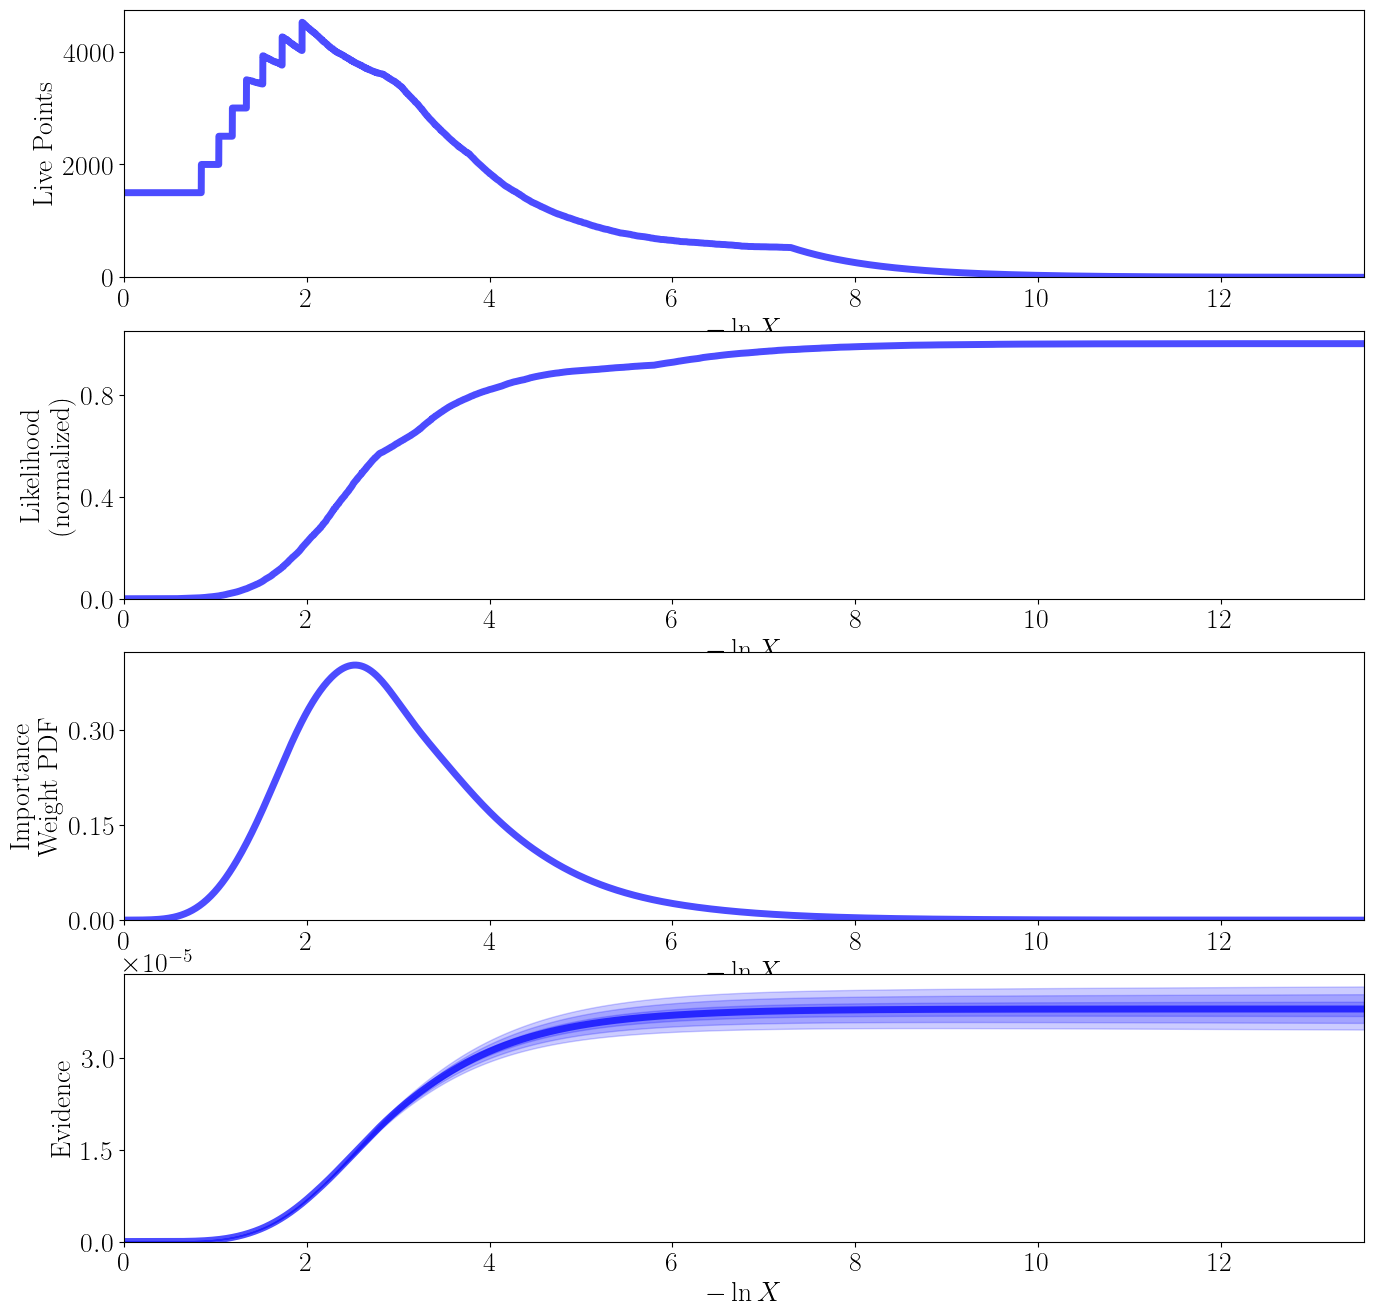

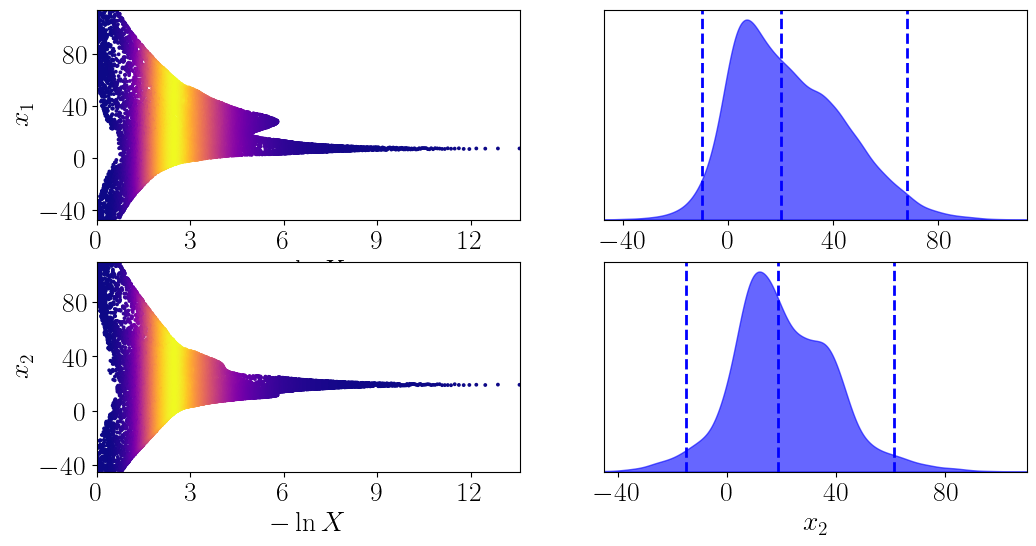

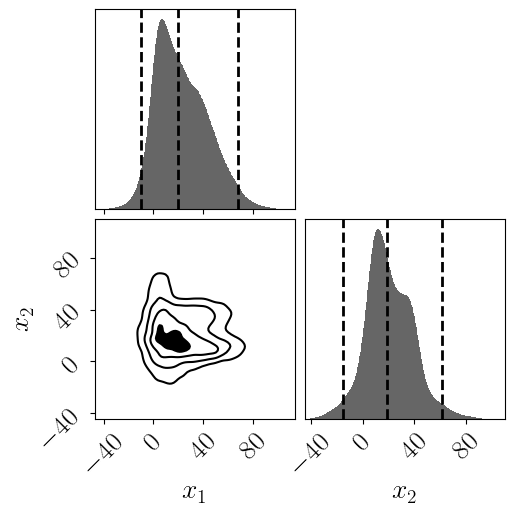

In [8]:
# Number of live points per sampler (static and dynamic). None if default.
nlive = None
# Tollerance. None if default
dlogZ = None

# Run MN_dynesty
import time
t0 = time.time()
#!python MN_dynesty.py $likelihood_label $ndims $ninput

import sys
import scipy.stats, scipy
from scipy.stats import multivariate_normal

limits = np.loadtxt(os.path.join(zflowpath, 'limits.txt'))
min_theta = limits[0,:]
max_theta = limits[1,:]
# print(min_theta, max_theta)
# print(np.min(samples, axis = 0), np.max(samples, axis = 0))

if(likelihood_label=='Likelihood-Exponential'):
    # Loading lambdas
    lambdas = np.loadtxt(os.path.join(zflowpath, 'lambdas.txt'))

elif(likelihood_label == 'Likelihood-Rosenbrock'):
    print('Rosenbrock! Ahhh')
    
elif N is not None:
    # Loading mean covariance and parameter limits (for the flat prior definition)
    means = np.load(os.path.join(zflowpath, 'means.npy'))
    covs = np.load(os.path.join(zflowpath, 'covs.npy'))
    print('Shape of means and covs: ', means.shape, covs.shape)


def loglike(x):
    # get the current parameter (is between transformed values of cube now)
    if(likelihood_label == 'Likelihood-Rosenbrock'):
        return log_pdf_rosenbrock(x)
        
    elif(likelihood_label=='Likelihood-Exponential'):
        global lambdas # Need to replace global
        # Calculate likelihood values for samples
        loglikelihood = n_dimensional_exponential_logpdf(x=x, lambdas=lambdas)
        return loglikelihood

    elif N is not None:
        global means, covs
        likelihood = 0
        
        for index in range(len(means)):
            mean = means[index]
            cov = covs[index]
            var = multivariate_normal(mean=mean, cov=cov)
            likelihood += var.pdf(x)
        likelihood /= N
    
        return np.log(likelihood)
        

savedir = os.path.join(zflowpath, 'MN-dynesty')
if not os.path.exists(savedir):
    os.makedirs(savedir)
    

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""
    for i in range(ndims):
        u[i] = u[i] * (max_theta[i] - min_theta[i])+min_theta[i]
    return u
    #return 10. * (2. * u - 1.)


# Estimating the evidence and posterior
import dynesty

# "Static" nested sampling.
if(nlive is None):
    sampler = dynesty.NestedSampler(loglike, ptform, ndims)
else:
    sampler = dynesty.NestedSampler(loglike, ptform, ndims, nlive=1500)
    
if(dlogZ is None):
    sampler.run_nested()
else:
    sampler.run_nested(dlogz = .005)
sresults = sampler.results

# "Dynamic" nested sampling.
if(nlive is None):
    dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndims)
else:
    dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndims, nlive=1500)

dsampler.run_nested()
dresults = dsampler.results


from dynesty import utils as dyfunc

# Combine results from "Static" and "Dynamic" runs.
results = dyfunc.merge_runs([sresults, dresults])


from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)


from dynesty import utils as dyfunc

# Extract sampling results.
samples_MN = results.samples  # samples
weights = results.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples_MN.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples_MN, weights)

# Resample weighted samples.
samples_equal = results.samples_equal()

# Commented out because it's giving weird results. But I've not done an in-depth analysis
## Generate a new set of results with sampling uncertainties.
#results_sim = dyfunc.resample_run(results)

tf = time.time()
delt = tf - t0
print('Total runtime: '+str(delt//3600)+'hr '+str((delt//60)%60)+'m '+str(np.round(delt%60, 2))+'s')

In [9]:
print(results.summary())
#print(results_sim.logz.max())
#plt.hist(results_sim.logz, bins = 1000)
#print(results_sim.logz.mean(), results_sim.logz.std(), results_sim.logzerr.max())
#plt.yscale('log')
#plt.xlim(left=-100)
#plt.show()
multinest_lnZ = [results.logz.max(), results.logzerr.max()]
print('\nMN mean {}, stddev {}'.format(multinest_lnZ[0], multinest_lnZ[1]))

Summary
niter: 14926
ncall: 73132
eff(%): 20.410
logz: -10.177 +/-  0.031
None

MN mean -10.176947857402878, stddev 0.0308466787454282


## Run kNN

In [10]:
MCMC_chain = np.hstack((np.ones(len(samples))[:, np.newaxis], log_likelihood[:, np.newaxis], samples))
# print(MCMC_chain)
# print('Prior Volume: ', np.prod(max_theta-min_theta))
np.savetxt(os.path.join(zflowpath, 'samples_nsamples[{}].txt'.format(ninput)), MCMC_chain)

In [11]:
try: 
    from MCEvidence import MCEvidence
except:
    !git clone https://github.com/yabebalFantaye/MCEvidence
    !cd MCEvidence
    !pip install . --editable
    #!pip install git+https://github.com/yabebalFantaye/MCEvidence
    from MCEvidence import MCEvidence

nsamples = ninput
# nsamples = 100000
MLE = MCEvidence.MCEvidence(os.path.join(zflowpath, 'samples_nsamples[{}].txt'.format(nsamples)), verbose = 2, ischain = True, split = True).evidence(pvolume = np.prod(max_theta-min_theta), pos_lnp=True, verbose = 2)

DEBUG:MCEvidence.py.__init__():707      Using chain: ./Likelihood-5Gaussian_2d_ninput[10000]_nbatch[200]_Linterval[25]/samples_nsamples[10000].txt
INFO:MCEvidence.py.setup():143      Loading chain from ./Likelihood-5Gaussian_2d_ninput[10000]_nbatch[200]_Linterval[25]/samples_nsamples[10000].txt
DEBUG:MCEvidence.py.load_from_file():573      Loading file assuming CosmoMC columns order: weight loglike param1 param2 ...
DEBUG:MCEvidence.py.load_from_file():603      Reading from files: ./Likelihood-5Gaussian_2d_ninput[10000]_nbatch[200]_Linterval[25]/samples_nsamples[10000].txt
INFO:MCEvidence.py.read_list_to_array():566      loading: ./Likelihood-5Gaussian_2d_ninput[10000]_nbatch[200]_Linterval[25]/samples_nsamples[10000].txt
DEBUG:MCEvidence.py.chains2samples():197      Chain2Sample: nchain=1
INFO:MCEvidence.py.chain_split():231      1 chain with nrow=10000 split to ns1=5000, ns2=5000
DEBUG:MCEvidence.py.__init__():773      using ndim=2
INFO:MCEvidence.py.__init__():783      chain array d

partition s1.shape (5000, 2)
partition s2.shape (5000, 2)


## Obtain real <--> latent space mapping

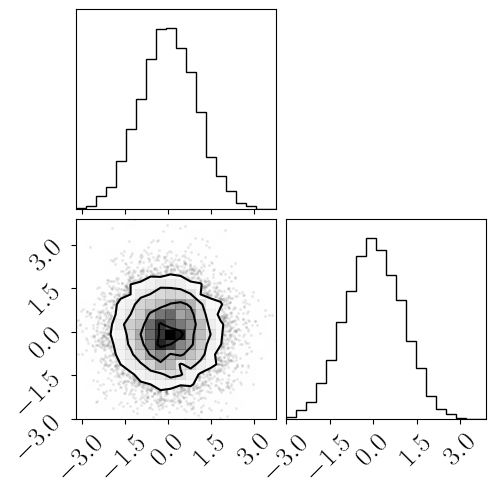

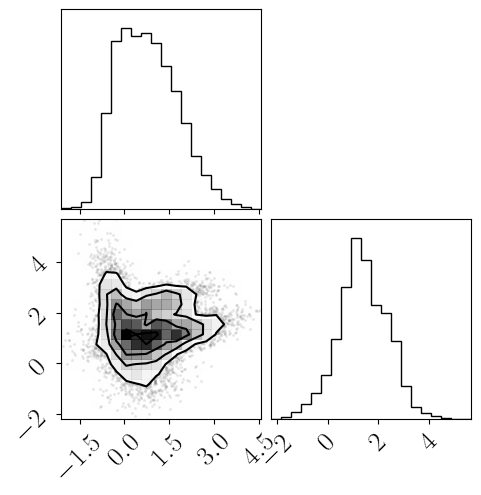

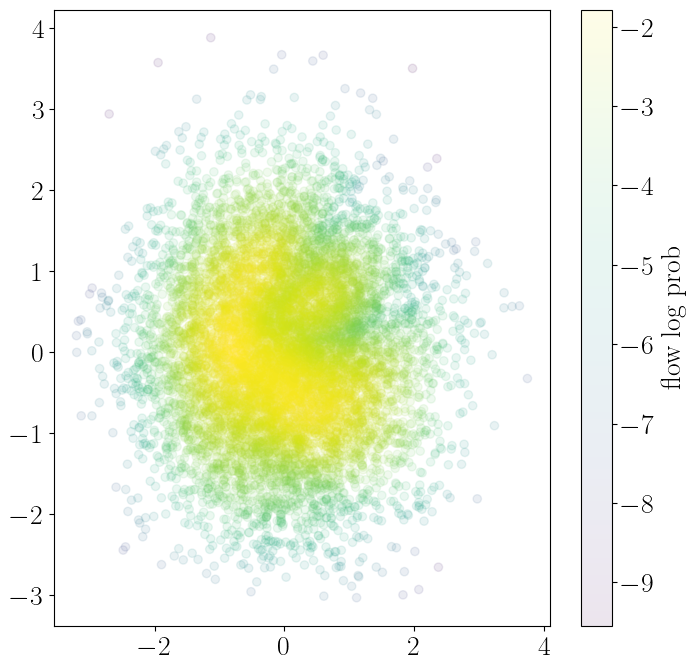

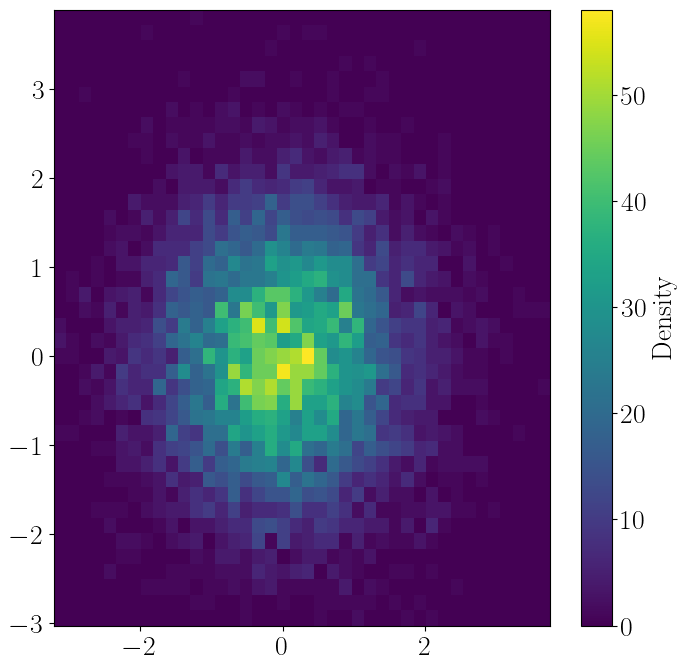

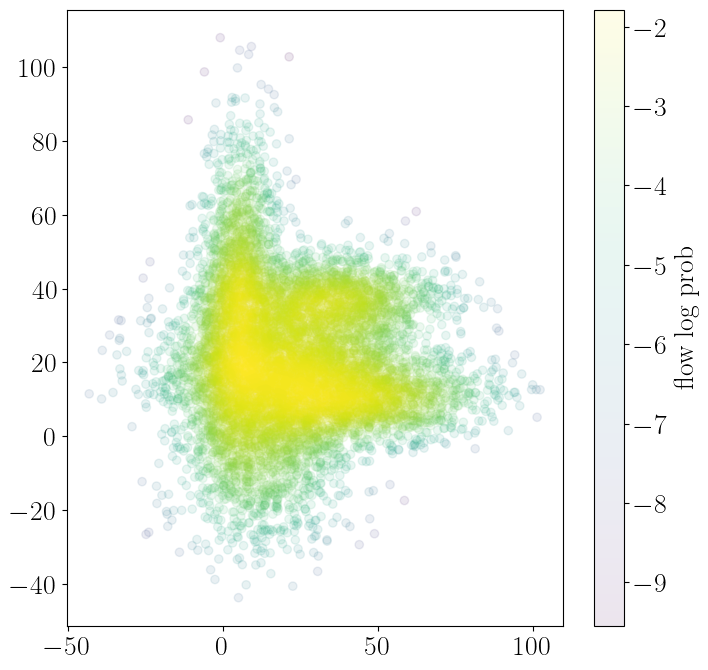

In [12]:
# samples_flow = t1.flow._transform(samples)
def _pre_whitening(samples):
    
    cov     = np.cov(samples.T)
    w, v    = np.linalg.eig(cov)
    
    # project samples
    output  = np.zeros(samples.shape)
    for i in range(len(w)): # run over dimensions
        for j in range(len(samples)): # run over samples
            output[j][i]  = (v[:,i]*samples[j]).sum()/np.sqrt(w[i])
            
    return output, 0.5*np.log(np.abs(np.prod(w)))

whitened_samples,_ = _pre_whitening(samples)

with torch.no_grad():
    latent_samples = torch.tensor(whitened_samples, dtype=torch.float32).to(torch.device('cuda'))
    flow_logprob = t1.flow.log_prob(latent_samples).detach().cpu().numpy()
    latent_samples, logabsdet = t1.flow._transform(latent_samples)
    latent_samples = latent_samples.detach().cpu().numpy()
    logabsdet = logabsdet.detach().cpu().numpy()
    # print(latent_samples, flow_logprob)
    corner.corner(latent_samples, title = 'Latent Space')
    corner.corner(whitened_samples, title = 'Real Space')
    
    if(ndims==2):
        plt.figure(figsize = (8,8))
        plt.scatter(latent_samples[:,0], latent_samples[:,1], c=flow_logprob, cmap='viridis', alpha = .1)
        plt.colorbar(label = 'flow log prob')
        plt.figure(figsize = (8,8))
        plt.hist2d(latent_samples[:,0], latent_samples[:,1], bins=40, cmap='viridis')
        plt.colorbar(label='Density')
        plt.figure(figsize = (8,8))
        plt.scatter(samples[:,0], samples[:,1], c=flow_logprob, cmap='viridis', alpha = .1)
        plt.colorbar(label = 'flow log prob')
        plt.show()

## Function to select samples within 1$\sigma$ ellispoid B in latent space

In [13]:
import numpy as np
from scipy.optimize import minimize

import numpy as np
from scipy.optimize import minimize


def get_restricted_ellipsoidB(theta_samples, log_prob_theta_samples, delta_squared = 1.):
    # Assuming theta_samples is a 2D NumPy array with shape (num_samples, num_dimensions)
    # and log_prob_theta_samples is a 1D NumPy array with shape (num_samples,)
    
    # Step 1: Compute mean and covariance matrix
    mean_theta = np.mean(theta_samples, axis=0)
    covariance_matrix_theta = np.cov(theta_samples, rowvar=False)
    
    # Step 2: Find the mode (MAP estimate)
    initial_guess = np.zeros(theta_samples.shape[1])  # Replace with a suitable initial guess
    
    result = minimize(lambda x: -np.sum(-0.5 * np.log(np.linalg.det(covariance_matrix_theta)) - 0.5 * np.sum((theta_samples - x) @ np.linalg.inv(covariance_matrix_theta) * (theta_samples - x), axis=1) + log_prob_theta_samples),
                      initial_guess, method='L-BFGS-B')
    
    theta_MAP = result.x
    
    # # Print results
    # print(f"Mean of theta: {mean_theta}")
    # print(f"Covariance matrix of theta:\n{covariance_matrix_theta}")
    # print(f"MAP estimate of theta: {theta_MAP}")
    
    # Assuming theta_samples is a 2D NumPy array with shape (num_samples, num_dimensions)
    # and theta_MAP is the MAP estimate from the previous code
    # and covariance_matrix_theta is the covariance matrix computed in the previous code
    
    # Define the threshold delta
    # delta_squared = 8.0
    
    # Compute the Mahalanobis distance for each sample
    mahalanobis_distances_squared = np.sum((theta_samples - theta_MAP) @ np.linalg.inv(covariance_matrix_theta) * (theta_samples - theta_MAP), axis=1)
    
    # Identify samples that satisfy the condition
    theta_samples_in_B = theta_samples[mahalanobis_distances_squared < delta_squared]
    log_p_in_B = log_prob_theta_samples[mahalanobis_distances_squared < delta_squared]
    # # Print results
    print(f"Number of samples in set B: {len(theta_samples_in_B)} out of total {len(theta_samples)}")

    return mahalanobis_distances_squared < delta_squared

## Z prediction

Evidence =  3.98166720479482e-05
log_e (Evidence) =  -10.131224837709091
10000 10000
Number of samples in set B: 6324 out of total 10000


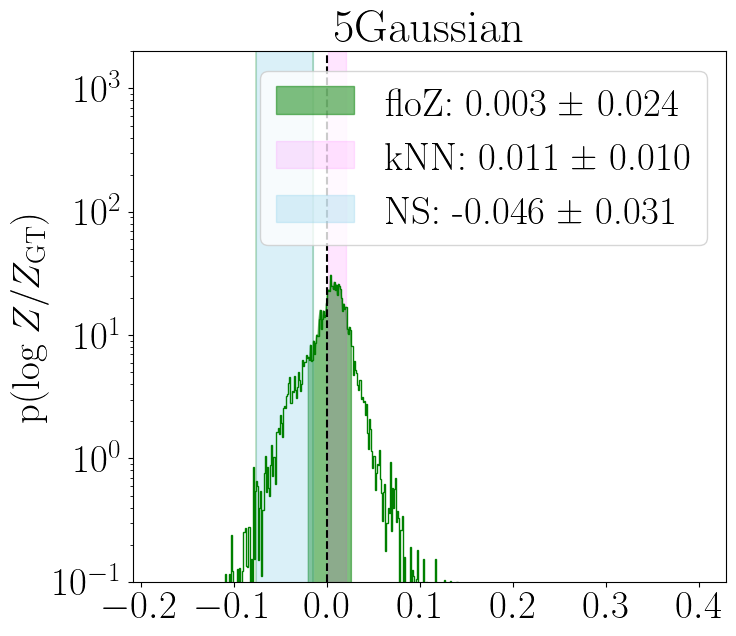

In [14]:
# Calculation of Evidence
print('Evidence = ', Z)
print('log_e (Evidence) = ', np.log(Z))

rescale_linear = -np.log(Z)

# Load flow logz
import torch

t1.flow.load_state_dict(torch.load(os.path.join(zflowpath, 'flow_state.pt')))
t1.flow.eval()

#logz = np.loadtxt(os.path.join(zflowpath, 'logz.txt'))
logz = t1._get_logz_from_samples().cpu()
lnZ = logz.detach().numpy()
lnP = np.array(log_p)

print(len(samples), len(lnP))
# Histogram the restricted set
delta_squared = 2.0

# restricted_set = get_restricted_ellipsoidB(theta_samples=samples, log_prob_theta_samples=lnP, delta_squared = delta_squared)
# restricted_set = np.where(np.sum( (latent_samples-latent_samples[flow_logprob.argmax()])**2, axis = 1) < delta_squared)[0]
restricted_set = np.where(np.sum( (latent_samples)**2, axis = 1) < delta_squared)[0]
print(f"Number of samples in set B: {len(restricted_set)} out of total {len(samples)}")
lnZ = lnZ[restricted_set]
lnP = lnP[restricted_set]

fig = plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 28})

bins = np.linspace(-.18, .4, 501)
# bins = np.arange(np.min(logz.detach().numpy())+rescale_linear, np.max(logz.detach().numpy())+rescale_linear, min((np.max(logz.detach().numpy())+rescale_linear-np.min(logz.detach().numpy())+rescale_linear)/1001, multinest_lnZ[1]+rescale_linear))
pdf, _, _ = plt.hist(logz+rescale_linear, density=True, bins=bins, histtype = 'step', color = 'grey', alpha = 0)#, label = 'Zflows')
bins_mean = (bins[1:] + bins[:-1])*.5
# Shade the regions of the zflows prediction
# print(pdf)
# plt.fill_between(bins_mean, 0, pdf, where=((bins_mean >= logz.detach().median().numpy()-logz.detach().std().numpy()) & (bins_mean <= logz.detach().median().numpy()+logz.detach().std().numpy())), color='orange', alpha=0.15, label=r'floZ: '+'{:.3f} ± {:.3f}'.format(logz.median(), logz.std()))


# bins = np.arange(np.min(lnZ), np.max(lnZ), min((np.max(lnZ)-np.min(lnZ))/101, multinest_lnZ[1]))
# pdf, _, _ = plt.hist(lnZ, density=True, bins=bins, histtype = 'step', alpha=0, color='grey')#, label = 'Zflow Ellipse')
pdf_reweight, _, _ = plt.hist(lnZ+rescale_linear, density=True, bins=bins, histtype = 'step', weights = np.exp(lnP), color = 'green')# label = 'Zflow Ellipse reweighted')
bins = (bins[1:] + bins[:-1])*.5
#print(bins[(bins >= multinest_lnZ[0]-multinest_lnZ[1]) & (bins <= multinest_lnZ[0]+multinest_lnZ[1])])
    
# # Shade the regions of the zflows prediction
# plt.fill_between(bins, 0, pdf, where=((bins >= np.median(lnZ)-np.std(lnZ)) & (bins <= np.median(lnZ)+np.std(lnZ))), color='skyblue', alpha=0.8, label=r'Zflows Ellipse: '+'{:.2f} ± {:.2f}'.format(np.median(lnZ), np.std(lnZ)))

def weighted_mean_and_std(values, weights):
    weighted_mean = np.average(values, weights=weights)
    variance = np.average((values - weighted_mean)**2, weights=weights)
    weighted_std = np.sqrt(variance)
    return weighted_mean, weighted_std
logz_mean_reweight, logz_std_reweight = weighted_mean_and_std(values=lnZ, weights=np.exp(lnP))
plt.fill_between(bins, 0, pdf_reweight, where=((bins >= logz_mean_reweight+rescale_linear - logz_std_reweight) & (bins <= logz_mean_reweight+rescale_linear + logz_std_reweight)), color='green', alpha=0.5, label=r'floZ'+': '+'{:.3f} ± {:.3f}'.format(logz_mean_reweight+rescale_linear, logz_std_reweight))#, label=r'floZ $\in \mathcal{B}$'+': '+'{:.3f} ± {:.3f}'.format(logz_mean_reweight, logz_std_reweight))

# Plot Heavens+2017 prediction
# MLE_sigma = MLE[0] - .5*np.log(1+nsamples)
# MLE_sigma = MLE[0]*(1+nsamples)**-.5
MLE_sigma = .5*( np.log( np.exp(MLE[0])*(1+1./(1+nsamples)**.5) ) - np.log( np.exp(MLE[0])*(1-1./(1+nsamples)**.5) ) )

# plt.axvline(MLE[0], c = 'cyan', ls = '--', lw = 2., label = 'Heavens+2017: {:.3f}'.format(MLE[0]))
plt.axvspan(MLE[0]-MLE_sigma+rescale_linear, MLE[0]+MLE_sigma+rescale_linear, alpha=0.1, color='magenta', label=r'kNN: '+'{:.3f} ± {:.3f}'.format(MLE[0]+rescale_linear, MLE_sigma))

# Shade the area of the multinest prediction
plt.axvspan(multinest_lnZ[0]-multinest_lnZ[1]+rescale_linear, multinest_lnZ[0]+multinest_lnZ[1]+rescale_linear, alpha=0.3, color='skyblue', label=r'NS: '+'{:.3f} ± {:.3f}'.format(multinest_lnZ[0]+rescale_linear,multinest_lnZ[1]))
plt.axvline(multinest_lnZ[0]-multinest_lnZ[1]+rescale_linear, c='green', ls = '-', lw=.3)
plt.axvline(multinest_lnZ[0]+multinest_lnZ[1]+rescale_linear, c='green', ls = '-', lw=.3)


plt.axvline(np.log(Z)+rescale_linear, c='k', ls = '--')#, label= 'GT: {:.2f}'.format(np.log(Z)))
# plt.xlabel('log $Z/Z_\rm{GT}$')
plt.xlabel('\n')
plt.ylabel('p(log $Z/Z_{\mathrm{GT}}$)')
# plt.ylabel('\n '
plt.yscale('log')
plt.ylim(1e-1, 2e3)
# plt.xlim(-.18, .3)

plt.title(likelihood_label.split('Likelihood-')[1])
# plt.gca().set_xticklabels([])
# plt.gca().set_yticklabels([])

# Add a legend with handle and label
handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend(handles=handles[:], labels=labels[:])#, loc = 'lower left')
plt.tight_layout()
plt.savefig(os.path.join(zflowpath, 'logZ_withGT_RestrictedSampling.png'), bbox_inches='tight')#, bbox_inches='tight')
plt.rcParams.update({'font.size': 20})

In [15]:
print('GT:\n{}'.format(np.log(Z)))
print('\nMN:\n{}, {}, {}'.format(multinest_lnZ[0]-multinest_lnZ[1], multinest_lnZ[0]+multinest_lnZ[1], results.niter))
# print('\nZflows:\n{}, {}, {}'.format(logz.median()-logz.std(), logz.median()+logz.std(), ninput))
print('\nZflows B:\n{}, {}, {}'.format(logz_mean_reweight-logz_std_reweight, logz_mean_reweight+logz_std_reweight, len(restricted_set)))
print('\nH17:\n{}, {}, {}'.format(MLE[0]-MLE_sigma,MLE[0]+MLE_sigma,nsamples))

GT:
-10.131224837709091

MN:
-10.207794536148306, -10.14610117865745, 14926

Zflows B:
-10.15280026625347, -10.104629578636652, 6324

H17:
-10.13067610392562, -10.110676437243956, 10000
